In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

/usr/local/lib/python3.5/dist-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/usr/local/lib/python3.5/dist-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/usr/local/lib/python3.5/dist-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/usr/local/lib/python3.5/dist-packages/tensorflow/python/framework/dtypes.py:519: FutureWarning: Passing (type, 1) or 

In [2]:
class critic(object):
    def __init__(self, sess):
        
        self.sess = sess
        ################################
        # Generator
        ################################
        
        # z --> latent space for generator
        self.z = tf.placeholder(dtype=tf.float32, shape=[None, 16])
        
        self.update_static_discriminator = (
            lambda x: self.copy_params(
                from_scope="discriminator", to_scope="discriminator_static"
            )
        )
        self.gen_out = self.generator(self.z)
        self.disc_g_z = self.discriminator(
            self.gen_out, trainable=False, scope_name="discriminator_static"
        )
        
        self.gen_loss = tf.reduce_mean(-1.*self.disc_g_z)
        self.gen_opt = tf.train.AdamOptimizer(learning_rate=0.0001, beta1=0, beta2=0.9)
        self.gen_min_opt = self.gen_opt.minimize(self.gen_loss)
        
        ################################
        # Discriminator
        ################################
        
        # w --> output from generator
        self.w = tf.placeholder(dtype=tf.float32, shape=[None, 2])
        # x --> from data
        self.x = tf.placeholder(dtype=tf.float32, shape=[None, 2])
        
        batch_size = tf.shape(self.w)[0]
        
        disc_w  = self.discriminator(self.w)
        disc_x  = self.discriminator(self.x)
        
        self.disc_out = tf.concat([disc_w, disc_x], axis=0)
        
        e = tf.random.uniform(shape=tf.shape(self.w), minval=0., maxval=1.)
        self.x_interp = e*self.x + (1 - e)*self.w
        
        disc_x_interp = self.discriminator(self.x_interp)
        
        self.grad_wrt_x = tf.gradients(
            disc_x_interp,
            [self.x_interp]
        )[0]
        
        self.disc_grad_penalty = tf.reduce_mean(
            tf.square(
                tf.sqrt(
                    tf.reduce_sum(self.grad_wrt_x*self.grad_wrt_x, axis=1)
                ) - 1.
            )
        )
        
        self.wg_disc_loss = tf.reduce_mean(disc_w - disc_x)
        
        self.disc_loss = self.wg_disc_loss + 10.*self.disc_grad_penalty
        
        self.disc_opt = tf.train.AdamOptimizer(learning_rate=0.0001, beta1=0, beta2=0.9)
        self.disc_min_opt = self.disc_opt.minimize(self.disc_loss)
        
        radius = 5
        num_centers = 6
        center_range = np.linspace(0, 2*np.pi - 2*np.pi/num_centers, num_centers)
        self.centers = [np.array([radius*np.cos(t), radius*np.sin(t)]) for t in center_range]
        
    def generator(self, Z_in, scope_name="generator"):
        with tf.variable_scope(scope_name, reuse=tf.AUTO_REUSE) as vs:
            num_layers = 3
        
            weights = []
            biases  = []
            layer_outs   = []

            ls = 16

            weights.append(tf.get_variable("w0", [16, ls], initializer=tf.initializers.orthogonal))
            biases.append(tf.get_variable("b0", [ls,], initializer=tf.initializers.random_normal))

            layer_outs.append(tf.nn.relu(tf.matmul(Z_in, weights[-1]) + biases[-1]))

            for l in range(num_layers):
                index = l + 1
                weights.append(
                    tf.get_variable(
                        "w" + str(index),
                        [ls, ls],
                        initializer=tf.initializers.orthogonal
                    )
                )
                biases.append(
                    tf.get_variable(
                        "b" + str(index),
                        [ls,],
                        initializer=tf.initializers.random_normal
                    )
                )
                layer_outs.append(tf.nn.relu(tf.matmul(layer_outs[-1], weights[-1]) + biases[-1]))

            weights.append(tf.get_variable("wout", [ls, 2], initializer=tf.initializers.orthogonal))
            biases.append(tf.get_variable("bout", [2,], initializer=tf.initializers.random_normal))

            full_out = tf.matmul(layer_outs[-1], weights[-1]) + biases[-1]
            
            return full_out
        
    def copy_params(self, from_scope, to_scope):
        old_params = [v for v in tf.global_variables() if from_scope in v.name]
        new_params = [v for v in tf.global_variables() if to_scope in v.name]
        
        assignments = [op.assign(np) for op, np in zip(old_params, new_params)]
        self.sess.run(assignments)
        
    def discriminator(self, X_in, trainable=True, scope_name="discriminator"):
        with tf.variable_scope(scope_name, reuse=tf.AUTO_REUSE) as vs:
            num_layers = 3
        
            weights = []
            biases  = []
            layer_outs   = []

            ls = 512

            weights.append(
                tf.get_variable(
                    "w0",
                    [2, ls],
                    initializer=tf.initializers.orthogonal,
                    trainable=trainable
                )
            )
            biases.append(
                tf.get_variable(
                    "b0",
                    [ls,],
                    initializer=tf.initializers.random_normal,
                    trainable=trainable
                )
            )

            layer_outs.append(tf.nn.relu(tf.matmul(X_in, weights[-1]) + biases[-1]))

            for l in range(num_layers):
                index = l + 1
                weights.append(
                    tf.get_variable(
                        "w" + str(index),
                        [ls, ls],
                        initializer=tf.initializers.orthogonal,
                        trainable=trainable
                    )
                )
                biases.append(
                    tf.get_variable(
                        "b" + str(index),
                        [ls,],
                        initializer=tf.initializers.random_normal,
                        trainable=trainable
                    )
                )
                layer_outs.append(tf.nn.relu(tf.matmul(layer_outs[-1], weights[-1]) + biases[-1]))

            weights.append(
                tf.get_variable(
                    "wout",
                    [ls, 1],
                    initializer=tf.initializers.orthogonal,
                    trainable=trainable
                )
            )
            biases.append(
                tf.get_variable(
                    "bout",
                    [1,],
                    initializer=tf.initializers.random_normal,
                    trainable=trainable
                )
            )

            full_out = tf.matmul(layer_outs[-1], weights[-1]) + biases[-1]
            
            return full_out
        
    def train_discriminator(self, use_generator=False, batch_size=512):
        true_samples = self.get_distribution_samples(batch_size//2)
        gen_samples = None
        if not use_generator:
            gen_samples = self.get_distribution_samples(batch_size//2)
            offsets = np.array([np.random.normal([0, 0], scale=1.5) for _ in range(batch_size//2)])
            gen_samples = gen_samples + offsets
        else:
            gen_feeds = {
                self.z: np.array([np.random.normal([0,]*16, scale=1.0) for _ in range(batch_size//2)])
            }
            
            gen_fetches = self.gen_out
            
            gen_samples = self.sess.run(gen_fetches, gen_feeds)
        
        disc_fetches = [
            self.disc_loss,
            self.disc_min_opt,
            self.disc_out,
            self.disc_grad_penalty,
            self.wg_disc_loss
        ]

        disc_feeds = {
            self.x: true_samples,
            self.w: gen_samples,
        }
        
        disc_loss, disc_opt, disc_out, disc_gp, disc_wgloss = self.sess.run(disc_fetches, disc_feeds)

        return disc_loss, disc_out, None, disc_gp, disc_wgloss
    
    def train_generator(self, batch_size=512):
        self.copy_params(
            from_scope="discriminator", to_scope="discriminator_static"
        )
        
        gen_feeds = {
            self.z: np.array([np.random.normal([0,]*16, scale=1.0) for _ in range(batch_size)])
        }

        gen_fetches = [
            self.gen_loss,
            self.gen_min_opt,
            self.gen_out,
        ]
        
        gen_loss, gen_opt, gen_out = self.sess.run(gen_fetches, gen_feeds)
    
    def output_surface(self):
        xs = np.linspace(-12, 12, 200)
        ys = np.linspace(-12, 12, 200)
        
        query_points = []
        for x in xs:
            for y in ys:
                query_points.append([x, y])
        query_points = np.array(query_points)
        
        fetches = self.disc_out
        feeds = {
            self.w: query_points[0:200*200//2, :],
            self.x: query_points[200*200//2:, :],
            #self.z: np.zeros([200*200//2, 2])
        }
        
        out = self.sess.run(fetches, feeds)
        return query_points, out
    
    def get_distribution_samples(self, N=64):
        samples = []
        for n in range(N):
            d = np.random.choice([i for i in range(len(self.centers))])
            sample = np.random.normal(loc=self.centers[d], scale=1.0)
            samples.append(sample)
        
        return np.array(samples)

In [3]:
sess = tf.Session()

c = critic(sess)
print(c.centers)
sess.run(tf.global_variables_initializer())

#print(c.train())

[array([5., 0.]), array([2.5       , 4.33012702]), array([-2.5       ,  4.33012702]), array([-5.00000000e+00, -1.60812265e-15]), array([-2.5       , -4.33012702]), array([ 2.5       , -4.33012702])]


In [4]:
#things = [np.random.normal([0, 0], scale=0.3) for _ in range(1000)]
things = c.get_distribution_samples(1000)

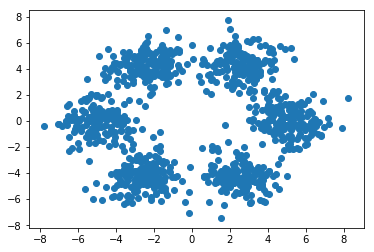

In [5]:
plt.figure()
plt.scatter([p[0] for p in things], [p[1] for p in things])
plt.show()

In [ ]:
ret = None
derivs = []
disc_losses = []
gen_losses = []
gandvs = []
gradpenalties = []
disc_wglosses = []
weights = []
for i in range(20000):
    disc_ret = c.train_discriminator(use_generator=True)
    #derivs.append(ret[-2])
    disc_losses.append(disc_ret[0])
    #gandvs.append(ret[2])
    gradpenalties.append(disc_ret[3])
    disc_wglosses.append(disc_ret[4])
    #weights.append(sess.run(c.weights))
    gen_ret = c.train_generator()
    if np.isnan(disc_losses[-1]):
        print("Received NaN during training. Stopping.")
        break
#print(gandvs[0])
#print("wglosses:", disc_wglosses)
#print("gradpenalties:", gradpenalties)

In [ ]:
print(ret[0])
print(ret[1].shape)
#print(ret[2])
print(max(disc_losses), min(disc_losses))
plt.figure()
plt.plot(np.log10(np.abs(disc_losses)))
plt.plot(disc_losses)
#plt.plot(gradpenalties/max(gradpenalties))
plt.legend(["log(loss)", "loss"])
plt.show()

In [ ]:
ret[1].shape

In [ ]:
ret[0].shape

In [ ]:
output_surface = c.output_surface()
b = np.max(output_surface[1])
a = np.min(output_surface[1])
y = output_surface[1]/(b - a) - a/(b - a)
plt.figure()
plt.scatter([p[0] for p in output_surface[0]], [p[1] for p in output_surface[0]], c=y[:, 0])
plt.show()

In [ ]:
#output_surface[1].shape
print(np.max(output_surface[1]), np.min(output_surface[1]))

In [ ]:
plt.figure()
plt.plot(gradpenalties)
plt.show()